# Twitter Sentiment Analysis

## Importing libraries

In [29]:
import os
import zipfile
import numpy as np
import pandas as pd
from scipy import stats
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
import seaborn as sns
import re
import nltk
import string
from gensim.utils import simple_preprocess
from sklearn.model_selection import train_test_split
import tensorflow as tf
#sns.set()

## Downloading and reading the dataset from Kaggle

In [2]:
! pip install kaggle==1.5.6
! kaggle datasets download -d kazanova/sentiment140


  0%|          | 0.00/80.9M [00:00<?, ?B/s]
  1%|          | 1.00M/80.9M [00:00<00:28, 2.89MB/s]
  2%|▏         | 2.00M/80.9M [00:00<00:18, 4.53MB/s]
  4%|▎         | 3.00M/80.9M [00:00<00:15, 5.14MB/s]
  5%|▍         | 4.00M/80.9M [00:00<00:14, 5.54MB/s]
  6%|▌         | 5.00M/80.9M [00:01<00:14, 5.67MB/s]
  7%|▋         | 6.00M/80.9M [00:01<00:13, 5.95MB/s]
  9%|▊         | 7.00M/80.9M [00:01<00:11, 6.47MB/s]
 10%|▉         | 8.00M/80.9M [00:01<00:11, 6.53MB/s]
 11%|█         | 9.00M/80.9M [00:01<00:11, 6.57MB/s]
 12%|█▏        | 10.0M/80.9M [00:01<00:12, 5.98MB/s]
 14%|█▎        | 11.0M/80.9M [00:01<00:11, 6.20MB/s]
 15%|█▍        | 12.0M/80.9M [00:02<00:11, 6.38MB/s]
 16%|█▌        | 13.0M/80.9M [00:02<00:10, 6.57MB/s]
 17%|█▋        | 14.0M/80.9M [00:02<00:10, 6.49MB/s]
 19%|█▊        | 15.0M/80.9M [00:02<00:11, 6.23MB/s]
 20%|█▉        | 16.0M/80.9M [00:02<00:10, 6.29MB/s]
 21%|██        | 17.0M/80.9M [00:02<00:10, 6.16MB/s]
 22%|██▏       | 18.0M/80.9M [00:03<00:10, 6.28MB/s]
 

In [3]:
with zipfile.ZipFile("sentiment140.zip","r") as zip_ref:
    zip_ref.extractall()

df = pd.read_csv('training.1600000.processed.noemoticon.csv', encoding = 'Latin-1', names=('target','id','date','flag','user','text'))


In [4]:
os.remove('training.1600000.processed.noemoticon.csv')
os.remove('sentiment140.zip')

In [5]:
df['sentiment'] = (df['target'] == 4)*1
df.head()

,target,id,date,flag,user,text,sentiment
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0


In [6]:
df.sentiment.value_counts()

0    800000
1    800000
Name: sentiment, dtype: int64

## Data Prep

Removing punctuations

In [7]:
def remove_punc(message):
  return ''.join([char for char in message if char not in string.punctuation])

df['text_wo_punctuation'] = df['text'].apply(remove_punc)

Removing stopwords

In [8]:
nltk.download('stopwords')
stop_words = nltk.corpus.stopwords.words('english')
stop_words.extend(['from', 'subject', 're', 'edu', 'use', 'will', 'aap', 'co', 'day', 'user', 'stock', 'today', 'week', 'year', 'https', 'amp'])
stop_words[:10]

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\andre\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're"]

In [9]:
def preprocess(text):
  return [word for word in simple_preprocess(text) if word not in stop_words and len(word) >= 3]

In [10]:
df['text_wo_punctuation_and_stopwords'] = df['text_wo_punctuation'].apply(preprocess)
df['text_wo_punctuation_and_stopwords_joined'] = df['text_wo_punctuation_and_stopwords'].apply(lambda x: " ".join(x))

In [11]:
df.head()

,target,id,date,flag,user,text,sentiment,text_wo_punctuation,text_wo_punctuation_and_stopwords,text_wo_punctuation_and_stopwords_joined
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t...",0,switchfoot httptwitpiccom2y1zl Awww thats a b...,"[switchfoot, httptwitpiccom, awww, thats, bumm...",switchfoot httptwitpiccom awww thats bummer sh...
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...,0,is upset that he cant update his Facebook by t...,"[upset, cant, update, facebook, texting, might...",upset cant update facebook texting might cry r...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...,0,Kenichan I dived many times for the ball Manag...,"[kenichan, dived, many, times, ball, managed, ...",kenichan dived many times ball managed save re...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire,0,my whole body feels itchy and like its on fire,"[whole, body, feels, itchy, like, fire]",whole body feels itchy like fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all....",0,nationwideclass no its not behaving at all im ...,"[nationwideclass, behaving, mad, cant, see]",nationwideclass behaving mad cant see


## Analysis

### 1. What are the most common words in POSITIVE sentiment tweets?

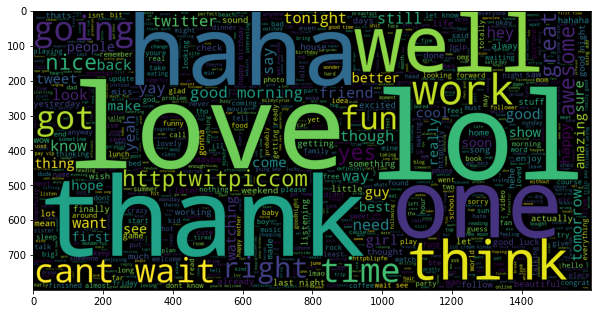

In [12]:
plt.figure(figsize= (10,10))
wc = WordCloud(
    max_words=1000, 
    width=1600,
    height=800
).generate(' '.join(df[df['sentiment'] == 1]['text_wo_punctuation_and_stopwords_joined']))
plt.imshow(wc)

### 2. What are the most common words in NEGATIVE sentiment tweets?

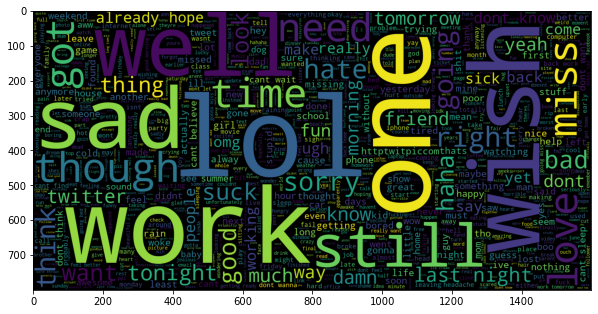

In [13]:
plt.figure(figsize= (10,10))
wc = WordCloud(
    max_words=1000, 
    width=1600,
    height=800
).generate(' '.join(df[df['sentiment'] == 0]['text_wo_punctuation_and_stopwords_joined']))
plt.imshow(wc)

### 3. Does the number of words in a tweet help determine whether it has positive or negative sentiment?

In [14]:
df['num_words'] = df['text_wo_punctuation_and_stopwords'].apply(lambda x : len(x))

<AxesSubplot:xlabel='num_words', ylabel='Count'>

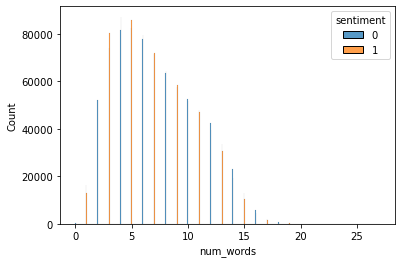

In [15]:
sns.histplot(data=df, x="num_words", hue="sentiment", multiple="dodge")

<AxesSubplot:xlabel='sentiment', ylabel='num_words'>

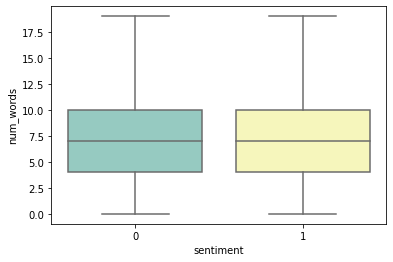

In [16]:
sns.boxplot(data=df, y="num_words", x="sentiment", palette="Set3", showfliers = False)

In [17]:
positive_lenghts = df[df['sentiment'] == 1].num_words
negative_lenghts = df[df['sentiment'] == 0].num_words

In [18]:
stats.ks_2samp(positive_lenghts, negative_lenghts)

KstestResult(statistic=0.019873750000000023, pvalue=1.1430950666558848e-137)

### 4. Is it possible to predict the sentiment of a new tweet using the existing ones?

#### a) Spliting the data in training, validation and test sets

In [20]:
df = df.sample(100000)

In [21]:
X = df['text_wo_punctuation_and_stopwords']
y = df['sentiment']

In [25]:
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size= 0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size= 0.3, random_state=42)

#### b) Data prep using Keras Tokenizer

In [27]:
list_of_words = []

for tweet in X_train:
    list_of_words += tweet

len(list_of_words)

397435

In [28]:
total_words = len(list(set(list_of_words)))
total_words

65680

In [30]:
tokenizer = tf.keras.preprocessing.text.Tokenizer(num_words=total_words)
tokenizer.fit_on_texts(X_train)

In [31]:
train_sequences = tokenizer.texts_to_sequences(X_train)
val_sequences = tokenizer.texts_to_sequences(X_val)

In [33]:
X_train[:5]

393263                                 [hungry, lunch, till]
1096012    [seandblogonaut, startedhavent, really, quotpl...
1259990    [imwendy, see, light, well, firefly, end, tunnel]
556601     [davidarchie, somehow, lost, votes, vote, repo...
478040     [goodmorning, tweeters, dang, cloudy, hope, ge...
Name: text_wo_punctuation_and_stopwords, dtype: object

In [32]:
train_sequences[:5]

[[458, 240, 232],
 [11051, 17405, 14, 17406, 112],
 [11052, 16, 785, 17, 11053, 228, 7011],
 [1190, 1401, 164, 3000, 656, 4751, 17407],
 [1506, 1903, 879, 1968, 32, 473, 11054]]

In [34]:
padded_train = tf.keras.preprocessing.sequence.pad_sequences(train_sequences, maxlen = 30)
padded_val = tf.keras.preprocessing.sequence.pad_sequences(val_sequences, maxlen = 30)

In [36]:
y_train_cat = tf.keras.utils.to_categorical(y_train, 2)
y_val_cat = tf.keras.utils.to_categorical(y_val, 2)

In [43]:
y_train[:5].values

array([0, 1, 1, 0, 0], dtype=int32)

In [42]:
y_train_cat[:5]

array([[1., 0.],
       [0., 1.],
       [0., 1.],
       [1., 0.],
       [1., 0.]], dtype=float32)

#### c) Creating a LSTM Neural Networks

###